<a href="https://colab.research.google.com/github/MStamirski/Optic-sensors/blob/main/ModelsIzopropanol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and functions for training and testing models

In [1]:
from google.colab import drive
drive.mount("/content/drive")
path = "drive/MyDrive/Colab_Notebooks/SDA_Upskill/"

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

In [4]:
df_izopropanol = pd.read_csv(path+"izopropanol.csv", sep="\t").iloc[:, 1:] # without index
df_izopropanol

,X1,X2,y
0,0.000001,9.1792,8.55510
1,0.000001,9.2003,8.67500
2,0.000001,9.1968,8.71160
3,0.000001,9.1028,8.71570
4,0.000001,9.0601,8.67920
...,...,...,...
21002,0.000002,2.9408,-0.98811
21003,0.000002,3.2277,-1.03650
21004,0.000002,2.8527,-1.05290
21005,0.000002,3.3101,-0.71383


In [5]:
def train_model(df):
  X = df[df.columns[:2]]
  y = df[df.columns[2]]

  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

  X_train_sc = scaler.fit_transform(X_train)
  X_val_sc = scaler.transform(X_val)
  
  model.fit(X_train_sc, y_train)

  return X_val_sc, y_val

In [6]:
def make_prediction(X_val_sc, y_val):
  y_pred = model.predict(X_val_sc)

  print("METRICS FOR VALIDATION DATASET:")
  print(f"MAE OF PREDICTION  : {round(mean_absolute_error(y_val, y_pred),4)}")
  print(f"MAPE OF PREDICTION : {round(mean_absolute_percentage_error(y_val, y_pred),4)}")
  print("\n")

In [12]:
def get_sensor_data(filename):
  records = []

  with open(path+"data/"+filename+".txt") as file:
    for data in file:
      record = data.strip().split(',')
      records.append(record)
  
  df = pd.DataFrame.from_records(records,columns=['X1', 'X2'])
  df['X1'] = df['X1'].astype('float')
  df['X2'] = df['X2'].astype('float')

  return df

In [16]:
def plot_izopropanol_test():

  print("TESTING MODEL ON REMAINING SENSORS\n")
  
  sensor_nbrs = [str(sens).zfill(2) for sens in range(8,11)] # test for 3 remaining sensors
  filenames_a = []
  filenames_i = []
  for sensor in sensor_nbrs:
    filename_a = "sensor"+sensor+"_air"
    filenames_a.append(filename_a)
    filename_i = "sensor"+sensor+"_izopropanol"
    filenames_i.append(filename_i)
  
  dframes_a = []
  for filename in filenames_a:
    df = get_sensor_data(filename)
    dframes_a.append(df)

  dframes_i = []
  for filename in filenames_i:
    df = get_sensor_data(filename)
    dframes_i.append(df)

  fig, axs = plt.subplots(1,3, figsize=(15,5))
  for i, ax in enumerate(fig.axes):

    A = dframes_a[i]
    A_sc = scaler.transform(A)
    y_pred = model.predict(A_sc) 
    mae = round(mean_absolute_error(dframes_i[i]['X2'], y_pred),4)
    mape = round(mean_absolute_percentage_error(dframes_i[i]['X2'], y_pred),4)

    ax.set_title("Izoprop., sensor"+str(i+8).zfill(2)+", MAE: "+str(mae)+", MAPE: "+str(mape))
    ax.plot(dframes_i[i]['X1'], dframes_i[i]['X2'], label = "ground truth", color = "r")
    ax.plot(A['X1'], y_pred, label = "prediction", color = "b")

    ax.legend(loc = "upper center")

  fig.show()

In [8]:
def test_model(df):
  X_val_sc, y_val = train_model(df)
  make_prediction(X_val_sc, y_val)
  plot_izopropanol_test()

# MLPRegressor

In [9]:
scaler = MinMaxScaler()

In [10]:
model = MLPRegressor(
  hidden_layer_sizes=(32, 16, 8, 4),
  activation='tanh',
  solver='adam',
  random_state=42,
  max_iter=300,
  batch_size=60)

METRICS FOR VALIDATION DATASET:
MAE OF PREDICTION  : 0.2633
MAPE OF PREDICTION : 0.0955


TESTING MODEL ON REMAINING SENSORS



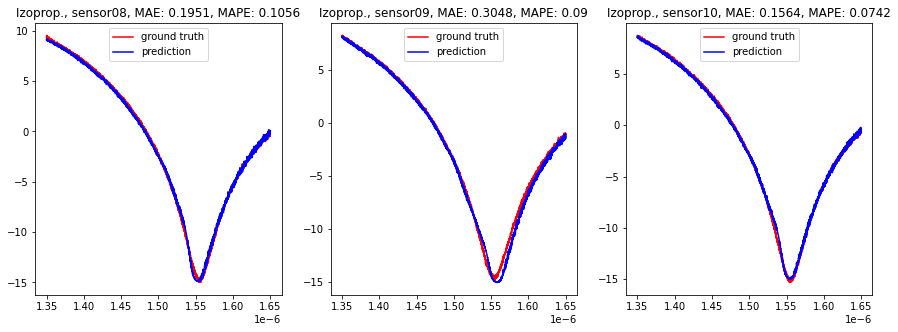

In [17]:
test_model(df_izopropanol)

# DecisionTreeRegressor

In [18]:
from sklearn.tree import DecisionTreeRegressor

In [19]:
model = DecisionTreeRegressor()

METRICS FOR VALIDATION DATASET:
MAE OF PREDICTION  : 0.2258
MAPE OF PREDICTION : 0.1184


TESTING MODEL ON REMAINING SENSORS



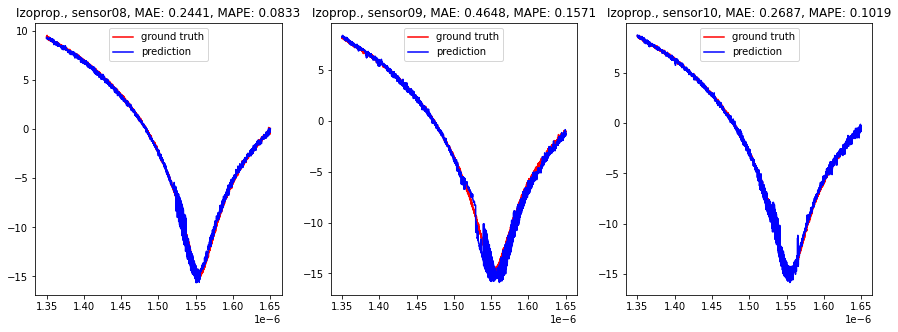

In [20]:
test_model(df_izopropanol)

# Sequential

In [21]:
from keras import models
from keras import layers
from keras.layers import Dense

In [22]:
def train_sequential_model(df):
  X = df[df.columns[:2]]
  y = df[df.columns[2]]

  X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

  X_train_sc = scaler.fit_transform(X_train)
  X_val_sc = scaler.transform(X_val)
  
  model.fit(X_train_sc, y_train, epochs=20, batch_size=60, validation_data=(X_val_sc, y_val))

  return X_val_sc, y_val

In [23]:
def test_sequential_model(df):
  X_val_sc, y_val = train_sequential_model(df)
  make_prediction(X_val_sc, y_val)
  plot_izopropanol_test()

In [24]:
model = models.Sequential()
model.add(Dense(32, activation='tanh', input_shape=(2,)))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics='mae')

Epoch 1/20
281/281 [==============================] - 2s 3ms/step - loss: 3.7799 - mae: 3.7799 - val_loss: 2.9687 - val_mae: 2.9687
Epoch 2/20
281/281 [==============================] - 1s 2ms/step - loss: 2.7144 - mae: 2.7144 - val_loss: 2.3344 - val_mae: 2.3344
Epoch 3/20
281/281 [==============================] - 1s 3ms/step - loss: 2.2122 - mae: 2.2122 - val_loss: 1.9510 - val_mae: 1.9510
Epoch 4/20
281/281 [==============================] - 1s 3ms/step - loss: 1.9001 - mae: 1.9001 - val_loss: 1.7105 - val_mae: 1.7105
Epoch 5/20
281/281 [==============================] - 1s 2ms/step - loss: 1.6957 - mae: 1.6957 - val_loss: 1.5425 - val_mae: 1.5425
Epoch 6/20
281/281 [==============================] - 1s 3ms/step - loss: 1.5597 - mae: 1.5597 - val_loss: 1.4441 - val_mae: 1.4441
Epoch 7/20
281/281 [==============================] - 1s 2ms/step - loss: 1.4590 - mae: 1.4590 - val_loss: 1.3862 - val_mae: 1.3862
Epoch 8/20
281/281 [==============================] - 1s 2ms/step - loss: 1.

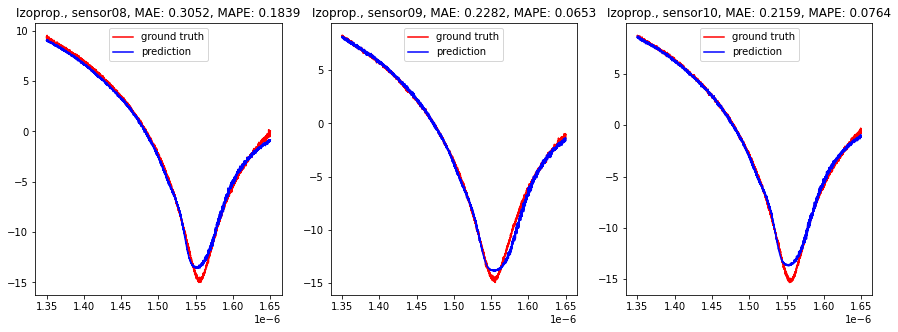

In [25]:
test_sequential_model(df_izopropanol)

# Conclusion

**The best model:**

**MLPRegressor, tanh, (32,16,8,4)**